In [0]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
import warnings
import re

from itertools import product
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import r2_score
import gc 
%matplotlib inline 
pd.set_option('display.max_rows',600)
pd.set_option('display.max_columns',50)
warnings.simplefilter(action='ignore', category=FutureWarning)

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    int8_cols = [col for col in df.columns if col in ['shop_id','date_block_num','item_category_id'] ]
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"] 
    int_cols = list(set(int_cols) - set(int8_cols))
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int16)
    df[int8_cols] = df[int8_cols].astype(np.int8)
    
    return df

os.environ['KAGGLE_USERNAME'] = "svgkat"
os.environ['KAGGLE_KEY'] = "85ffe6ac1c5ea0226c2f7a857e9dc63e"

!mkdir /content/predict_future_sales
!cd /content/predict_future_sales/

!kaggle competitions download -c competitive-data-science-predict-future-sales -p /content/predict_future_sales

sales = pd.read_csv('/content/predict_future_sales/sales_train.csv.gz')
shops = pd.read_csv('/content/predict_future_sales/shops.csv')
items = pd.read_csv('/content/predict_future_sales/items.csv')
item_cats = pd.read_csv('/content/predict_future_sales/item_categories.csv')
test = pd.read_csv('/content/predict_future_sales/test.csv.gz')    

sales = downcast_dtypes(sales)
shops = downcast_dtypes(shops)
items= downcast_dtypes(items)
item_cats = downcast_dtypes(item_cats)
test = downcast_dtypes(test)

test.drop(columns='ID',inplace=True)
test['date_block_num'] = sales.date_block_num.max() + 1


In [2]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

#Adding the test data to ensure that the test data is also part of the 
#feature engineering process
grid = pd.concat([grid, test])

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect()

0

In [3]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128050 entries, 0 to 11128049
Data columns (total 6 columns):
shop_id           int8
item_id           int32
date_block_num    int8
target            float32
target_shop       float32
target_item       float32
dtypes: float32(3), int32(1), int8(2)
memory usage: 275.9 MB


In [0]:
all_data.target_item = all_data.target_item.astype(np.int16)
all_data.target_shop = all_data.target_shop.astype(np.int16)
all_data.target = all_data.target.astype(np.int16)

In [0]:
all_data.item_id = all_data.item_id.astype(np.int16)

In [6]:
sales_ret = sales[sales.item_cnt_day < 0]

## return numbers for shop-month
gb = sales_ret.groupby(by=['shop_id','date_block_num'],as_index=False).agg({'item_cnt_day':{'trg_ret_shop_per_mth':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

del gb
gc.collect()

##return numbers for item-month

gb = sales_ret.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'trg_ret_item_mth':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

del gb
gc.collect()

##return numbers for shop-item-month

#gb = sales_ret.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'trg_ret_shop_item_mth':'sum'}})
#gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
#all_data = pd.merge(all_data, gb, how='left', on=index_cols).fillna(0)

#del gb
del sales_ret
gc.collect()

0

In [7]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128050 entries, 0 to 11128049
Data columns (total 8 columns):
shop_id                 int8
item_id                 int16
date_block_num          int8
target                  int16
target_shop             int16
target_item             int16
trg_ret_shop_per_mth    float32
trg_ret_item_mth        float32
dtypes: float32(2), int16(4), int8(2)
memory usage: 275.9 MB


In [8]:
(all_data.trg_ret_shop_per_mth == all_data.trg_ret_shop_per_mth.astype(np.int8)).all()

True

In [9]:
(all_data.trg_ret_item_mth == all_data.trg_ret_item_mth.astype(np.int8)).all()

True

In [0]:
all_data.trg_ret_item_mth = all_data.trg_ret_item_mth.astype(np.int8)
all_data.trg_ret_shop_per_mth = all_data.trg_ret_shop_per_mth.astype(np.int8)

In [11]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128050 entries, 0 to 11128049
Data columns (total 8 columns):
shop_id                 int8
item_id                 int16
date_block_num          int8
target                  int16
target_shop             int16
target_item             int16
trg_ret_shop_per_mth    int8
trg_ret_item_mth        int8
dtypes: int16(4), int8(4)
memory usage: 212.3 MB


In [12]:
sales_distinct_items_dm = sales[['date_block_num','item_id']].drop_duplicates().groupby(by=['date_block_num']).agg({'item_id':{'distinct_items_in_month':'count'}})
sales_distinct_items_dm.columns = [col[0] if col[-1]=='' else col[-1] for col in sales_distinct_items_dm.columns.values] 
sales_distinct_items_dm.distinct_items_in_month = sales_distinct_items_dm.distinct_items_in_month.astype(np.int16)
all_data = pd.merge(all_data,sales_distinct_items_dm,how='left',on='date_block_num').fillna(0)
del sales_distinct_items_dm
gc.collect()

0

In [13]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128050 entries, 0 to 11128049
Data columns (total 9 columns):
shop_id                    int8
item_id                    int16
date_block_num             int8
target                     int16
target_shop                int16
target_item                int16
trg_ret_shop_per_mth       int8
trg_ret_item_mth           int8
distinct_items_in_month    float64
dtypes: float64(1), int16(4), int8(4)
memory usage: 297.2 MB


In [14]:
sales_distinct_items_dm = sales[['date_block_num','shop_id','item_id']].drop_duplicates().groupby(by=['date_block_num','shop_id']).agg({'item_id':{'ditems_in_month_shop':'count'}})
sales_distinct_items_dm.columns = [col[0] if col[-1]=='' else col[-1] for col in sales_distinct_items_dm.columns.values] 
sales_distinct_items_dm.ditems_in_month_shop = sales_distinct_items_dm.ditems_in_month_shop.astype(np.int16)
all_data = pd.merge(all_data,sales_distinct_items_dm,how='left',on=['date_block_num','shop_id']).fillna(0)
del sales_distinct_items_dm
gc.collect()

0

In [15]:
(all_data.distinct_items_in_month == all_data.distinct_items_in_month.astype(np.int16)).all()

True

In [16]:
(all_data.ditems_in_month_shop == all_data.ditems_in_month_shop.astype(np.int16)).all()

True

In [0]:
all_data.ditems_in_month_shop = all_data.ditems_in_month_shop.astype(np.int16)
all_data.distinct_items_in_month = all_data.distinct_items_in_month.astype(np.int16)

In [18]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128050 entries, 0 to 11128049
Data columns (total 10 columns):
shop_id                    int8
item_id                    int16
date_block_num             int8
target                     int16
target_shop                int16
target_item                int16
trg_ret_shop_per_mth       int8
trg_ret_item_mth           int8
distinct_items_in_month    int16
ditems_in_month_shop       int16
dtypes: int16(6), int8(4)
memory usage: 254.7 MB


In [0]:
trg_ret_cols = ['trg_ret_shop_per_mth','trg_ret_item_mth']
cols_target_lags = list(set(list(all_data.columns)) - (set(index_cols)|set(trg_ret_cols)))

In [20]:
cols_target_lags

['target_shop',
 'distinct_items_in_month',
 'target',
 'ditems_in_month_shop',
 'target_item']

In [21]:
shift_range = [1,2,3,6,9,12]
for month_shift in shift_range:
	print('Processing:',month_shift)
	train_shift = all_data[index_cols + cols_target_lags].copy()
	train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
	foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_target_lags else x
	train_shift = train_shift.rename(columns=foo)
	all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift
gc.collect()

Processing: 1
Processing: 2
Processing: 3
Processing: 6
Processing: 9
Processing: 12


0

In [22]:
(all_data.target_lag_1 == all_data.target_lag_1.astype(np.int16)).all()

True

In [0]:
float_cols = [col for col in all_data if all_data[col].dtype == 'float64']

In [24]:
float_cols

['target_shop_lag_1',
 'distinct_items_in_month_lag_1',
 'target_lag_1',
 'ditems_in_month_shop_lag_1',
 'target_item_lag_1',
 'target_shop_lag_2',
 'distinct_items_in_month_lag_2',
 'target_lag_2',
 'ditems_in_month_shop_lag_2',
 'target_item_lag_2',
 'target_shop_lag_3',
 'distinct_items_in_month_lag_3',
 'target_lag_3',
 'ditems_in_month_shop_lag_3',
 'target_item_lag_3',
 'target_shop_lag_6',
 'distinct_items_in_month_lag_6',
 'target_lag_6',
 'ditems_in_month_shop_lag_6',
 'target_item_lag_6',
 'target_shop_lag_9',
 'distinct_items_in_month_lag_9',
 'target_lag_9',
 'ditems_in_month_shop_lag_9',
 'target_item_lag_9',
 'target_shop_lag_12',
 'distinct_items_in_month_lag_12',
 'target_lag_12',
 'ditems_in_month_shop_lag_12',
 'target_item_lag_12']

In [0]:
all_data[float_cols] = all_data[float_cols].astype(np.int16)

In [26]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128050 entries, 0 to 11128049
Data columns (total 40 columns):
shop_id                           int8
item_id                           int16
date_block_num                    int8
target                            int16
target_shop                       int16
target_item                       int16
trg_ret_shop_per_mth              int8
trg_ret_item_mth                  int8
distinct_items_in_month           int16
ditems_in_month_shop              int16
target_shop_lag_1                 int16
distinct_items_in_month_lag_1     int16
target_lag_1                      int16
ditems_in_month_shop_lag_1        int16
target_item_lag_1                 int16
target_shop_lag_2                 int16
distinct_items_in_month_lag_2     int16
target_lag_2                      int16
ditems_in_month_shop_lag_2        int16
target_item_lag_2                 int16
target_shop_lag_3                 int16
distinct_items_in_month_lag_3     int16
target_la

In [27]:
#create lags for the return feature
shift_trg_range = [1,2,3]
for month_shift in shift_trg_range:
  print('Processing:',month_shift)
  train_shift = all_data[index_cols + trg_ret_cols].copy()
  train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
  foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in trg_ret_cols else x
  train_shift = train_shift.rename(columns=foo)
  all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift
gc.collect()

Processing: 1
Processing: 2
Processing: 3


22

In [28]:
(all_data.trg_ret_shop_per_mth_lag_3 == all_data.trg_ret_shop_per_mth_lag_3.astype(np.int8)).all()

True

In [29]:
(all_data.trg_ret_item_mth_lag_3 == all_data.trg_ret_item_mth_lag_3.astype(np.int8)).all()

True

In [0]:
all_data.trg_ret_shop_per_mth_lag_1 = all_data.trg_ret_shop_per_mth_lag_1.astype(np.int8)
all_data.trg_ret_item_mth_lag_1 = all_data.trg_ret_item_mth_lag_1.astype(np.int8)
all_data.trg_ret_shop_per_mth_lag_2 = all_data.trg_ret_shop_per_mth_lag_2.astype(np.int8)
all_data.trg_ret_item_mth_lag_2 = all_data.trg_ret_item_mth_lag_2.astype(np.int8)
all_data.trg_ret_shop_per_mth_lag_3 = all_data.trg_ret_shop_per_mth_lag_3.astype(np.int8)
all_data.trg_ret_item_mth_lag_3 = all_data.trg_ret_item_mth_lag_3.astype(np.int8)

In [31]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128050 entries, 0 to 11128049
Data columns (total 46 columns):
shop_id                           int8
item_id                           int16
date_block_num                    int8
target                            int16
target_shop                       int16
target_item                       int16
trg_ret_shop_per_mth              int8
trg_ret_item_mth                  int8
distinct_items_in_month           int16
ditems_in_month_shop              int16
target_shop_lag_1                 int16
distinct_items_in_month_lag_1     int16
target_lag_1                      int16
ditems_in_month_shop_lag_1        int16
target_item_lag_1                 int16
target_shop_lag_2                 int16
distinct_items_in_month_lag_2     int16
target_lag_2                      int16
ditems_in_month_shop_lag_2        int16
target_item_lag_2                 int16
target_shop_lag_3                 int16
distinct_items_in_month_lag_3     int16
target_la

In [0]:
all_data = all_data[all_data['date_block_num'] >= 12] 

In [33]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488756 to 11128049
Data columns (total 46 columns):
shop_id                           int8
item_id                           int16
date_block_num                    int8
target                            int16
target_shop                       int16
target_item                       int16
trg_ret_shop_per_mth              int8
trg_ret_item_mth                  int8
distinct_items_in_month           int16
ditems_in_month_shop              int16
target_shop_lag_1                 int16
distinct_items_in_month_lag_1     int16
target_lag_1                      int16
ditems_in_month_shop_lag_1        int16
target_item_lag_1                 int16
target_shop_lag_2                 int16
distinct_items_in_month_lag_2     int16
target_lag_2                      int16
ditems_in_month_shop_lag_2        int16
target_item_lag_2                 int16
target_shop_lag_3                 int16
distinct_items_in_month_lag_3     int16
targ

In [34]:
item_cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
item_category_name    84 non-null object
item_category_id      84 non-null int8
dtypes: int8(1), object(1)
memory usage: 884.0+ bytes


In [35]:
vectorizer_item_cat = TfidfVectorizer(min_df=3,max_features=10)
X = vectorizer_item_cat.fit_transform(item_cats.item_category_name)
print('Count of features:',len(vectorizer_item_cat.get_feature_names()))
print(vectorizer_item_cat.get_feature_names())
df_item_cat_feat = pd.DataFrame(X.toarray())
for ind in range(len(vectorizer_item_cat.get_feature_names())):
  item_cats['tfidf_feat_itemcat_'+str(ind)] = df_item_cat_feat[ind]
del vectorizer_item_cat,X

item_item_cats = pd.merge(items.drop(columns=['item_name']),item_cats.drop(columns=['item_category_name']),how='left',on='item_category_id')
item_item_cats = downcast_dtypes(item_item_cats)
del df_item_cat_feat
gc.collect()

all_data = pd.merge(all_data,item_item_cats,how='left',on='item_id')
all_data = downcast_dtypes(all_data)
del item_item_cats
gc.collect()

Count of features: 10
['xbox', 'аксессуары', 'игровые', 'игры', 'кино', 'книги', 'консоли', 'музыка', 'подарки', 'цифра']


0

In [36]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 0 to 6639293
Data columns (total 57 columns):
shop_id                           int8
item_id                           int16
date_block_num                    int8
target                            int16
target_shop                       int16
target_item                       int16
trg_ret_shop_per_mth              int8
trg_ret_item_mth                  int8
distinct_items_in_month           int16
ditems_in_month_shop              int16
target_shop_lag_1                 int16
distinct_items_in_month_lag_1     int16
target_lag_1                      int16
ditems_in_month_shop_lag_1        int16
target_item_lag_1                 int16
target_shop_lag_2                 int16
distinct_items_in_month_lag_2     int16
target_lag_2                      int16
ditems_in_month_shop_lag_2        int16
target_item_lag_2                 int16
target_shop_lag_3                 int16
distinct_items_in_month_lag_3     int16
target_lag_

In [37]:
vectorizer = TfidfVectorizer(min_df=2,max_features=10)
X = vectorizer.fit_transform(shops.shop_name)
print('Count of features:',len(vectorizer.get_feature_names()))
print(vectorizer.get_feature_names())

df_shop_features = pd.DataFrame(X.toarray())
for ind in range(len(vectorizer.get_feature_names())):
  shops['tfidf_feat_shop_'+str(ind)] = df_shop_features[ind]

## Merge the shop features to all_data
all_data = pd.merge(all_data,shops.drop(columns=['shop_name']),how='left',on='shop_id')
all_data = downcast_dtypes(all_data)
del vectorizer,df_shop_features, X
gc.collect()

Count of features: 10
['воронеж', 'мега', 'молл', 'москва', 'тк', 'трк', 'трц', 'тц', 'тюмень', 'якутск']


24

In [0]:
import re

In [0]:
def identify_train_feat(feat_name):
  mt = re.search('[\d]+$',feat_name)
  if mt:
    return True
  else:
    return False

In [0]:
all_data['month'] = (all_data.date_block_num%12)+1

In [41]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 0 to 6639293
Data columns (total 68 columns):
shop_id                           int8
item_id                           int16
date_block_num                    int8
target                            int16
target_shop                       int16
target_item                       int16
trg_ret_shop_per_mth              int8
trg_ret_item_mth                  int8
distinct_items_in_month           int16
ditems_in_month_shop              int16
target_shop_lag_1                 int16
distinct_items_in_month_lag_1     int16
target_lag_1                      int16
ditems_in_month_shop_lag_1        int16
target_item_lag_1                 int16
target_shop_lag_2                 int16
distinct_items_in_month_lag_2     int16
target_lag_2                      int16
ditems_in_month_shop_lag_2        int16
target_item_lag_2                 int16
target_shop_lag_3                 int16
distinct_items_in_month_lag_3     int16
target_lag_

In [0]:
##test_feat_cols = ['shop_item_in_test_only','shop_item_in_train_and_test','shop_item_in_train_only']
test_feat_cols = []
##new_feat_cols = ['distinct_items_in_month','ditems_in_month_shop','month']
new_feat_cols = ['month']
fit_cols = [col for col in all_data.columns if identify_train_feat(col)]
fit_cols = list(set(fit_cols)|set(new_feat_cols))
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols)|set(test_feat_cols))) + ['date_block_num'] 

In [43]:
to_drop_cols

['target_shop',
 'distinct_items_in_month',
 'target',
 'trg_ret_shop_per_mth',
 'trg_ret_item_mth',
 'item_category_id',
 'ditems_in_month_shop',
 'target_item',
 'date_block_num']

In [44]:
fit_cols

['ditems_in_month_shop_lag_9',
 'target_item_lag_12',
 'ditems_in_month_shop_lag_12',
 'target_shop_lag_6',
 'trg_ret_shop_per_mth_lag_2',
 'tfidf_feat_itemcat_0',
 'target_lag_3',
 'target_shop_lag_9',
 'target_item_lag_9',
 'tfidf_feat_shop_4',
 'target_item_lag_3',
 'tfidf_feat_shop_9',
 'target_shop_lag_12',
 'target_shop_lag_1',
 'distinct_items_in_month_lag_1',
 'trg_ret_item_mth_lag_1',
 'distinct_items_in_month_lag_3',
 'tfidf_feat_shop_7',
 'ditems_in_month_shop_lag_6',
 'target_item_lag_6',
 'target_lag_12',
 'target_shop_lag_2',
 'ditems_in_month_shop_lag_2',
 'ditems_in_month_shop_lag_3',
 'target_lag_6',
 'target_lag_9',
 'target_shop_lag_3',
 'tfidf_feat_shop_6',
 'tfidf_feat_itemcat_4',
 'ditems_in_month_shop_lag_1',
 'distinct_items_in_month_lag_2',
 'target_lag_2',
 'tfidf_feat_itemcat_6',
 'distinct_items_in_month_lag_9',
 'tfidf_feat_shop_2',
 'target_item_lag_2',
 'tfidf_feat_itemcat_7',
 'trg_ret_item_mth_lag_2',
 'tfidf_feat_itemcat_2',
 'tfidf_feat_shop_3',
 'tar

In [47]:
to_drop_cols

['distinct_items_in_month',
 'item_category_id',
 'trg_ret_shop_per_mth',
 'trg_ret_item_mth',
 'target_item',
 'target_shop',
 'ditems_in_month_shop',
 'target',
 'date_block_num']

In [45]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 0 to 6639293
Data columns (total 68 columns):
shop_id                           int8
item_id                           int16
date_block_num                    int8
target                            int16
target_shop                       int16
target_item                       int16
trg_ret_shop_per_mth              int8
trg_ret_item_mth                  int8
distinct_items_in_month           int16
ditems_in_month_shop              int16
target_shop_lag_1                 int16
distinct_items_in_month_lag_1     int16
target_lag_1                      int16
ditems_in_month_shop_lag_1        int16
target_item_lag_1                 int16
target_shop_lag_2                 int16
distinct_items_in_month_lag_2     int16
target_lag_2                      int16
ditems_in_month_shop_lag_2        int16
target_item_lag_2                 int16
target_shop_lag_3                 int16
distinct_items_in_month_lag_3     int16
target_lag_

In [0]:
##Prepping the data for training
test_block = 34
vald_block = 33

dates = all_data['date_block_num']
test_block = dates.unique()[-1]

In [0]:
X_train = all_data.loc[dates < vald_block].drop(to_drop_cols,axis = 1)
y_train = all_data.loc[dates <  vald_block, 'target'].values

X_vald = all_data.loc[dates == vald_block].drop(to_drop_cols,axis=1)
y_vald = all_data.loc[dates ==  vald_block, 'target'].values

X_test= all_data.loc[dates == test_block].drop(to_drop_cols,axis = 1)
y_test = all_data.loc[dates ==  test_block, 'target'].values

In [48]:
gc.collect()

0

In [56]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }
model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), num_boost_round=100, valid_sets=[lgb.Dataset(X_vald, label=y_vald)], early_stopping_rounds=5)

[1]	valid_0's rmse: 5.30754
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 5.27243
[3]	valid_0's rmse: 5.25123
[4]	valid_0's rmse: 5.22456
[5]	valid_0's rmse: 5.19832
[6]	valid_0's rmse: 5.16932
[7]	valid_0's rmse: 5.14043
[8]	valid_0's rmse: 5.12422
[9]	valid_0's rmse: 5.09789
[10]	valid_0's rmse: 5.0797
[11]	valid_0's rmse: 5.05606
[12]	valid_0's rmse: 5.0438
[13]	valid_0's rmse: 5.02028
[14]	valid_0's rmse: 5.00214
[15]	valid_0's rmse: 4.98749
[16]	valid_0's rmse: 4.96629
[17]	valid_0's rmse: 4.95527
[18]	valid_0's rmse: 4.93658
[19]	valid_0's rmse: 4.91752
[20]	valid_0's rmse: 4.90426
[21]	valid_0's rmse: 4.89382
[22]	valid_0's rmse: 4.8816
[23]	valid_0's rmse: 4.86388
[24]	valid_0's rmse: 4.84651
[25]	valid_0's rmse: 4.83207
[26]	valid_0's rmse: 4.81909
[27]	valid_0's rmse: 4.81378
[28]	valid_0's rmse: 4.80036
[29]	valid_0's rmse: 4.79049
[30]	valid_0's rmse: 4.78683
[31]	valid_0's rmse: 4.77927
[32]	valid_0's rmse: 4.77031
[33]	valid_0's rmse: 4.

In [0]:
lgb_pred = model.predict(X_test).clip(0,20)

In [0]:
df_pred = pd.DataFrame()
df_pred['lgb_pred'] = lgb_pred

In [64]:
pd.Series(model.feature_importance(),index=X_train.columns).sort_values(ascending=False)

item_id                           1582
month                             1015
target_item_lag_1                  713
target_lag_1                       558
shop_id                            504
target_lag_2                       331
target_lag_3                       299
distinct_items_in_month_lag_1      276
ditems_in_month_shop_lag_1         276
tfidf_feat_itemcat_9               261
distinct_items_in_month_lag_2      232
target_item_lag_2                  221
target_shop_lag_1                  219
target_lag_6                       203
distinct_items_in_month_lag_12     181
tfidf_feat_itemcat_3               181
target_item_lag_3                  168
distinct_items_in_month_lag_3      161
tfidf_feat_shop_3                  152
tfidf_feat_itemcat_4               146
distinct_items_in_month_lag_6      128
target_shop_lag_2                  115
target_lag_9                       113
tfidf_feat_shop_5                  111
ditems_in_month_shop_lag_2         104
distinct_items_in_month_l

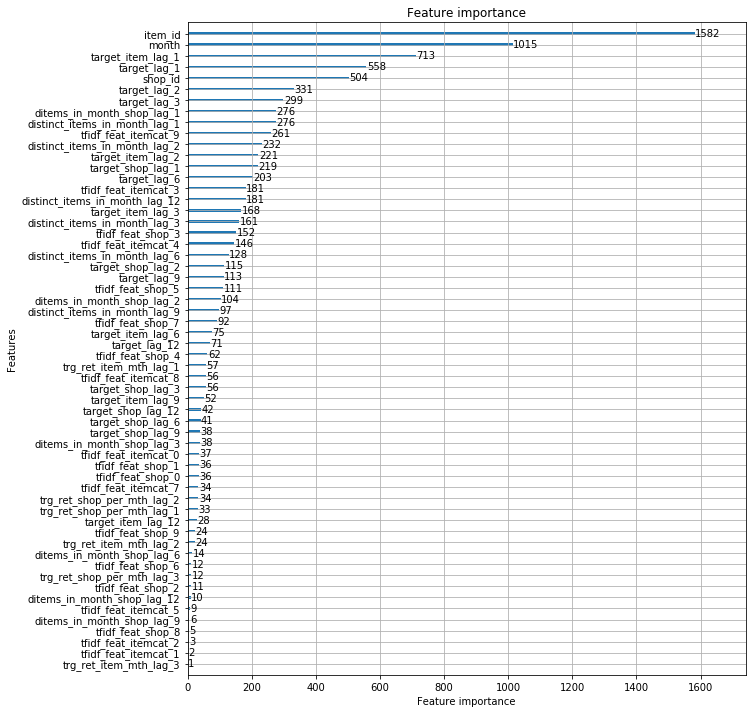

In [66]:
lgb.plot_importance(model,figsize=(10,12))

In [0]:
from xgboost import XGBRegressor
from xgboost import plot_importance

In [0]:
xgb_model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

xgb_model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_vald, y_vald)], 
    verbose=True, 
    early_stopping_rounds = 10)

In [0]:
pred_xgb = xgb_model.predict(X_test).clip(0,20)

In [0]:
df_pred['xgb_pred'] = pred_xgb

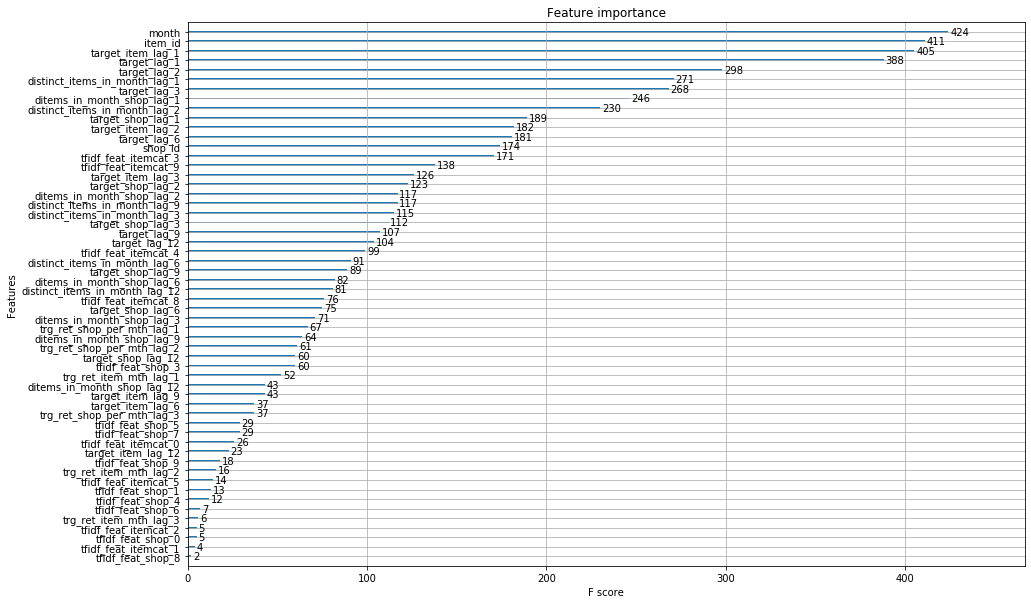

In [74]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
plot_importance(booster=xgb_model,ax=ax)

In [0]:
df_pred.to_csv('lgb_xgb.csv',index=False)

In [0]:
!pip install catboost

In [0]:
##Catboost 
from catboost import CatBoostRegressor

In [0]:
catb = CatBoostRegressor(
    iterations=100,
    random_seed=0,
    learning_rate=0.1,
    max_ctr_complexity=3, # To enable feature interactions
    has_time=True, # To disable random permutations
    boosting_type='Ordered', # To reduce overfitting
    loss_function='RMSE',
    od_type='Iter', 
    od_wait=10, # Early stopping    
)

In [53]:
catb.fit(X_train,y_train,cat_features=None,eval_set=(X_vald,y_vald),verbose=10)

0:	learn: 3.3836307	test: 5.2709601	best: 5.2709601 (0)	total: 995ms	remaining: 1m 38s
10:	learn: 2.6633986	test: 4.8421287	best: 4.8421287 (10)	total: 7.85s	remaining: 1m 3s
20:	learn: 2.4922300	test: 4.7019456	best: 4.7019456 (20)	total: 14.5s	remaining: 54.6s
30:	learn: 2.4190437	test: 4.6302003	best: 4.6302003 (30)	total: 21.2s	remaining: 47.2s
40:	learn: 2.3642970	test: 4.6193479	best: 4.6193479 (40)	total: 27.7s	remaining: 39.9s
50:	learn: 2.3221707	test: 4.6090871	best: 4.6090871 (50)	total: 34.2s	remaining: 32.8s
60:	learn: 2.2954846	test: 4.6021593	best: 4.6014330 (59)	total: 40.8s	remaining: 26.1s
70:	learn: 2.2833007	test: 4.6017512	best: 4.6008276 (65)	total: 47.4s	remaining: 19.4s
80:	learn: 2.2680420	test: 4.6005408	best: 4.6002825 (75)	total: 53.9s	remaining: 12.7s
90:	learn: 2.2541333	test: 4.5945723	best: 4.5942969 (87)	total: 1m	remaining: 5.99s
99:	learn: 2.2418513	test: 4.5839504	best: 4.5839504 (99)	total: 1m 6s	remaining: 0us

bestTest = 4.58395038
bestIteration =

In [0]:
catb_pred = catb.predict(X_test).clip(0,20)

In [70]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
lgb_pred    214200 non-null float64
xgb_pred    214200 non-null float64
catb        214200 non-null float64
dtypes: float64(3)
memory usage: 4.9 MB


In [77]:
print(catb.get_feature_importance( prettified=True)) 

                        Feature Id  Importances
0                     target_lag_1    42.587802
1                     target_lag_3     6.224143
2                     target_lag_2     5.655678
3                            month     4.887641
4                     target_lag_6     4.644093
5             tfidf_feat_itemcat_9     4.194084
6                target_shop_lag_1     3.621534
7                target_item_lag_1     3.064757
8             tfidf_feat_itemcat_3     2.431548
9                target_item_lag_2     2.278016
10               target_item_lag_3     2.197295
11      ditems_in_month_shop_lag_1     2.115114
12               target_shop_lag_9     1.702931
13                    target_lag_9     1.522467
14      ditems_in_month_shop_lag_6     1.373482
15      ditems_in_month_shop_lag_3     1.215721
16  distinct_items_in_month_lag_12     1.172587
17   distinct_items_in_month_lag_3     1.052710
18   distinct_items_in_month_lag_9     0.957812
19      trg_ret_shop_per_mth_lag_1     0

In [0]:
df_pred['item_cnt_month'] = df_pred.apply(lambda x: (x.lgb_pred + x.xgb_pred + x.catb )/3,axis=1) 

In [0]:
y_lgb_classifier = all_data.loc[dates <  vald_block, 'target'].apply(lambda x: 1 if x>0 else 0).values

In [0]:
y_vald_classifier = all_data.loc[dates ==  vald_block, 'target'].apply(lambda x: 1 if x>0 else 0).values

In [86]:
#Add a lightgbm classifier to predict if an item is purchased 
classifier_params = {
               'feature_fraction': 0.75,
               'metric': 'auc', 
               'nthread': 1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.3, 
               'objective': 'binary', 
               'bagging_seed': 2**7, 
               'num_leaves': 80,
               'bagging_freq':1,
               'is_unbalance':True,
               'verbose':0 
              }
lgb_train_ds  = lgb.Dataset(X_train,label=y_lgb_classifier)
lgb_vald_ds = lgb.Dataset(X_vald,label=y_vald_classifier) 

lgb_classifier = lgb.train(classifier_params, lgb_train_ds, valid_sets=[lgb_vald_ds],early_stopping_rounds=10,num_boost_round=100,verbose_eval=10 )


Training until validation scores don't improve for 10 rounds.
[10]	valid_0's auc: 0.841829
[20]	valid_0's auc: 0.846875
[30]	valid_0's auc: 0.848425
[40]	valid_0's auc: 0.848881
[50]	valid_0's auc: 0.84922
[60]	valid_0's auc: 0.851586
[70]	valid_0's auc: 0.851548
[80]	valid_0's auc: 0.852032
[90]	valid_0's auc: 0.852531
[100]	valid_0's auc: 0.85253
Early stopping, best iteration is:
[90]	valid_0's auc: 0.852531


In [0]:
classifier_probability = lgb_classifier.predict(X_test)

In [89]:
classifier_probability

array([0.56620624, 0.61620529, 0.85574245, ..., 0.18773221, 0.1364755 ,
       0.14568583])

In [135]:
df_pred.head()

,lgb_pred,xgb_pred,catb,item_cnt_month
0,0.459279,0.818846,0.895314,0.724480
1,0.177813,0.215463,0.264770,0.219349
2,1.024425,1.344738,0.976149,1.115104
3,0.330896,0.432817,0.572263,0.445325
4,1.351798,3.656095,1.351658,2.119850


In [0]:
## Notes: probability greater than 0.5 will indicate that the shop will sell that item

In [0]:
df_pred['classifier_prob'] = classifier_probability

In [137]:
df_pred.head()

,lgb_pred,xgb_pred,catb,item_cnt_month,classifier_prob
0,0.459279,0.818846,0.895314,0.724480,0.566206
1,0.177813,0.215463,0.264770,0.219349,0.616205
2,1.024425,1.344738,0.976149,1.115104,0.855742
3,0.330896,0.432817,0.572263,0.445325,0.674469
4,1.351798,3.656095,1.351658,2.119850,0.784047


In [0]:
df_pred.rename({'item_cnt_month':'average'},inplace=True,axis=1)

In [0]:
df_pred['item_cnt_month'] = df_pred.apply(lambda x: x.average if x.classifier_prob > 0.5 else 0,axis=1)

In [0]:
df_pred[df_pred.item_cnt_month == 0]

In [0]:
df_pred['ID'] = df_pred.index.to_list()

In [0]:
df_pred[['ID','item_cnt_month']].to_csv('sub_lgb_xg_cb.csv',index=False)

In [152]:
!ls -ltra 

total 9684
drwxr-xr-x 1 root root    4096 Nov 15 16:31 sample_data
drwxr-xr-x 1 root root    4096 Nov 15 16:31 .config
drwxr-xr-x 1 root root    4096 Nov 19 10:54 ..
drwxr-xr-x 2 root root    4096 Nov 19 11:11 predict_future_sales
drwxr-xr-x 4 root root    4096 Nov 19 11:28 catboost_info
drwx------ 3 root root    4096 Nov 19 11:32 drive
-rw------- 1 root root 6490008 Nov 19 11:36 lgb_xgb.csv
drwxr-xr-x 1 root root    4096 Nov 19 12:49 .
-rw-r--r-- 1 root root 3392566 Nov 19 12:50 sub_lgb_xg_cb.csv


In [153]:
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f sub_lgb_xg_cb.csv -m "lgb + cgb + cb + lgb calssifier"

100% 3.24M/3.24M [00:01<00:00, 2.48MB/s]
Successfully submitted to Predict Future Sales

In [0]:
df_pred[['ID','average']].rename({'average':'item_cnt_month'},axis=1).to_csv('lgb_xgb_cb_avg.csv',index=False)

In [158]:
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f lgb_xgb_cb_avg.csv -m "lgb + cgb + cb average"

100% 5.31M/5.31M [00:01<00:00, 2.98MB/s]
Successfully submitted to Predict Future Sales

In [159]:
!ls -ltra 

total 15120
drwxr-xr-x 1 root root    4096 Nov 15 16:31 sample_data
drwxr-xr-x 1 root root    4096 Nov 15 16:31 .config
drwxr-xr-x 1 root root    4096 Nov 19 10:54 ..
drwxr-xr-x 2 root root    4096 Nov 19 11:11 predict_future_sales
drwxr-xr-x 4 root root    4096 Nov 19 11:28 catboost_info
drwx------ 3 root root    4096 Nov 19 11:32 drive
-rw------- 1 root root 6490008 Nov 19 11:36 lgb_xgb.csv
-rw-r--r-- 1 root root 3392566 Nov 19 12:50 sub_lgb_xg_cb.csv
drwxr-xr-x 1 root root    4096 Nov 19 12:56 .
-rw-r--r-- 1 root root 5564571 Nov 19 12:56 lgb_xgb_cb_avg.csv


In [162]:
print('The ensemble plus the probability classifier is yielding a piblic score of 0.93845')
print('The ensemble alone is resulting a public score of 0.94849')

The ensemble plus the probability classifier is yielding a piblic score of 0.93845
The ensemble alone is resulting a public score of 0.94849
